# Dog Breed Classification using InceptionV3 CNN Model on Stanford Dogs Dataset
<!-- ## Abstract -->
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

I have used the InceptionV3 CNN Model, which is pre-trained on the ImageNet dataset for classification. Data augementation has been used for making the model generalize better and also to avoid overfitting. The model achieved an accuracy of 80% on validation set, which is decent enough for this dataset.

# Installing and Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

df =pd.read_csv("drive/My Drive/dataset/")
df.head()

/content


In [ ]:
import requests
import tarfile
dataset_path = "DatasetStore"

if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

  packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
  packet_file = os.path.basename(packet_url)
  packet_file = os.path.join(dataset_path, packet_file)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(packet_file, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

# Dataset

In [ ]:
train_data_dir = "./DatasetStore/Images/"
img_width, img_height = 224, 224
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [ ]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])

        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02106550-Rottweiler : n02106550_5133.jpg
n02099429-curly-coated_retriever : n02099429_2838.jpg
n02095889-Sealyham_terrier : n02095889_5899.jpg
n02107142-Doberman : n02107142_21.jpg
n02110627-affenpinscher : n02110627_6869.jpg
n02092002-Scottish_deerhound : n02092002_198.jpg
n02109525-Saint_Bernard : n02109525_16487.jpg
n02089078-black-and-tan_coonhound : n02089078_2110.jpg
n02102480-Sussex_spaniel : n02102480_5452.jpg
n02099267-flat-coated_retriever : n02099267_1922.jpg
n02090379-redbone : n02090379_1359.jpg
n02115641-dingo : n02115641_1674.jpg
n02087046-toy_terrier : n02087046_3843.jpg
n02104029-kuvasz : n02104029_3491.jpg
n02107312-miniature_pinscher : n02107312_2716.jpg
n02108089-boxer : n02108089_4002.jpg
n02106662-German_shepherd : n02106662_13123.jpg
n02108422-bull_mastiff : n02108422_3621.jpg
n02101556-clumber : n02101556_1680.jpg
n02091244-Ibizan_hound : n02091244_583.jpg
n02110806-basenji : n02110806_2249.jpg
n02112018-Pomeranian : n02112018_4928.jpg
n02086646-Blenheim_spanie

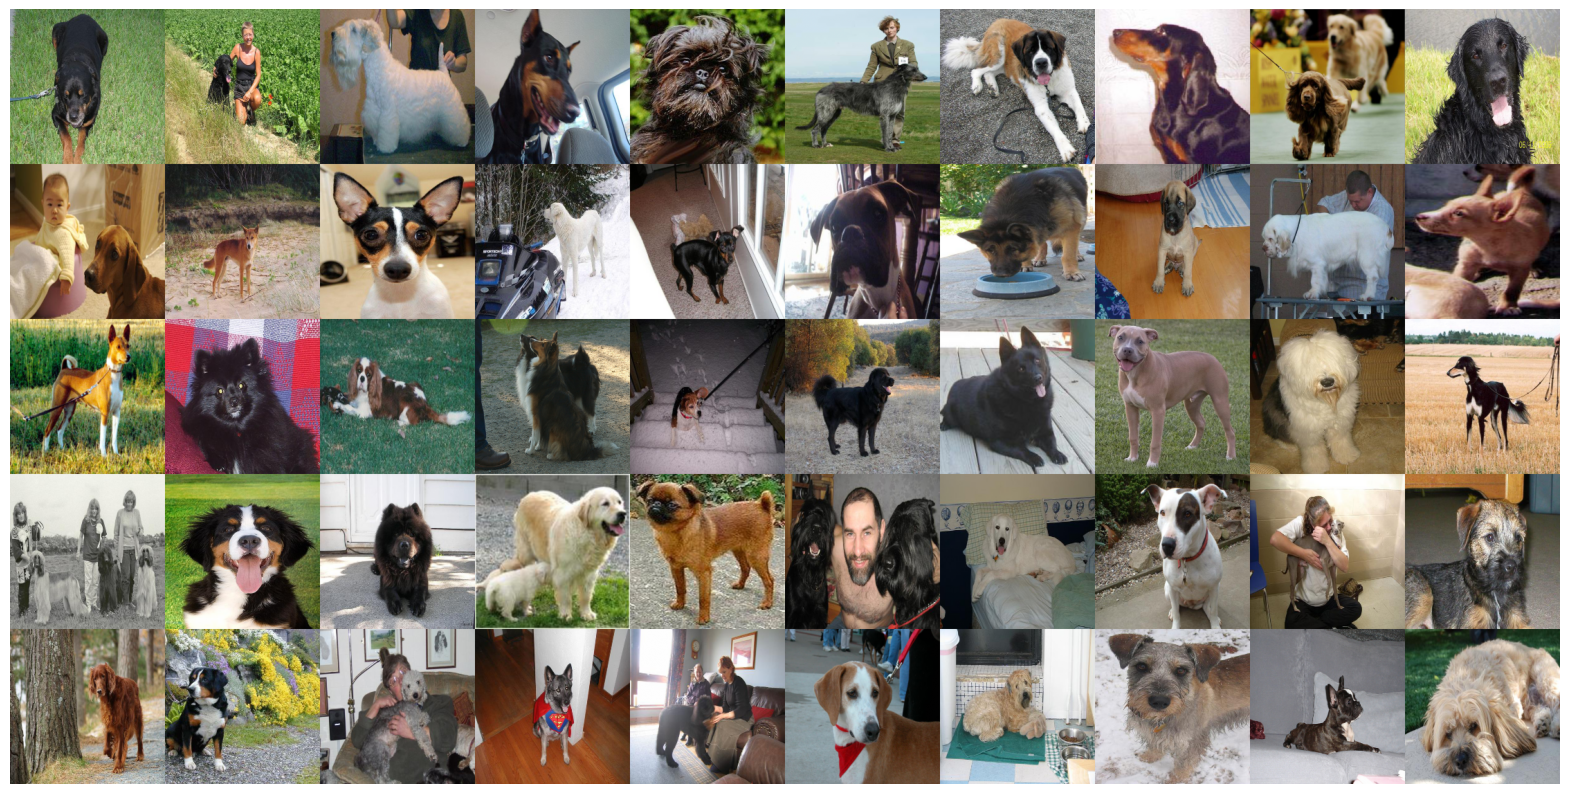

In [ ]:
images, labels = get_images(train_data_dir)
plot_images(images)

# Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)
nb_valid_samples = len(valid_generator.filenames)

print(nb_train_samples)
print(nb_valid_samples)

16508
4072


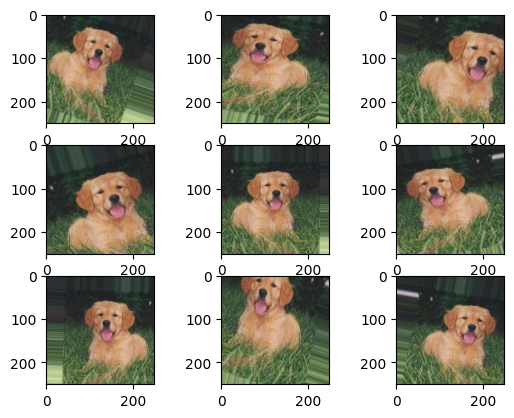

In [ ]:
img = load_img('./DatasetStore/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# Model

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)

model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


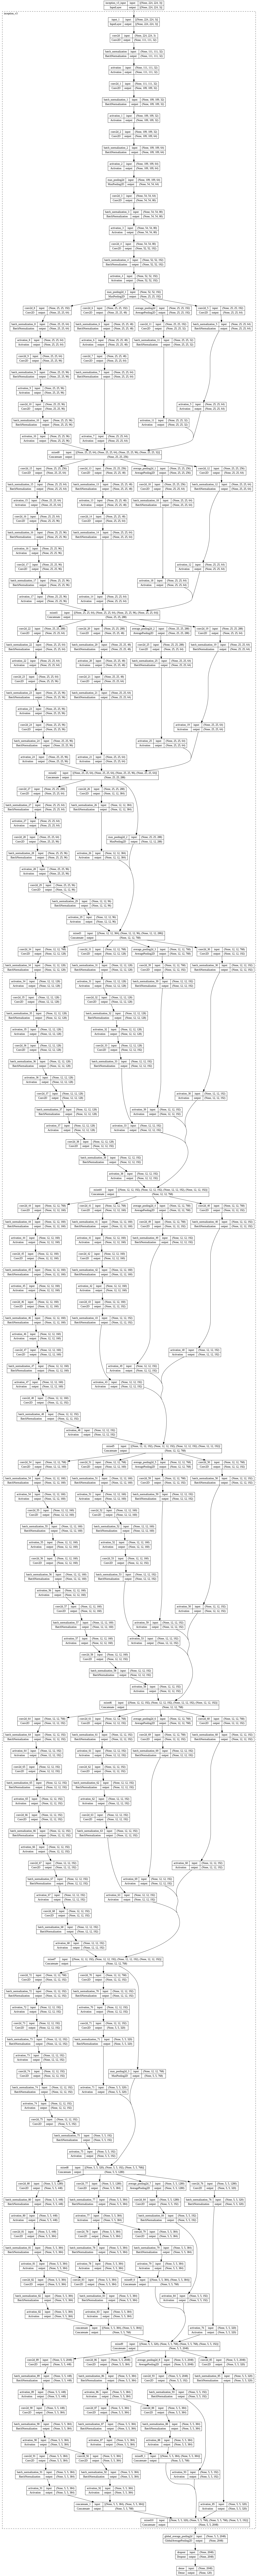

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Baseline Model Training

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
# checkpoint = ModelCheckpoint(
#     'baseline_model.h5',
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True,
#     mode='auto',
#     save_weights_only=False,
#     save_freq=1
# )

# earlystop = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=3,
#     verbose=1,
#     mode='auto'
# )

# csvlogger = CSVLogger(
#     filename= "training_csv.log",
#     separator = ",",
#     append = False
# )

# reduceLR = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     verbose=1,
#     mode='auto'
# )

# callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

import time

earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

checkpoint_filepath = 'baseline_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_generator,
        validation_data=valid_generator,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=30,
        verbose=1,
        steps_per_epoch=nb_train_samples/batch_size,
        validation_steps=nb_valid_samples/batch_size)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/30
258/257 [==============================] - ETA: 0s - loss: 3.3746 - accuracy: 0.2935
Epoch 1: val_accuracy improved from -inf to 0.68566, saving model to baseline_model.h5
257/257 [==============================] - 296s 1s/step - loss: 3.3746 - accuracy: 0.2935 - val_loss: 1.7016 - val_accuracy: 0.6857
Epoch 2/30
258/257 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.6383
Epoch 2: val_accuracy improved from 0.68566 to 0.76965, saving model to baseline_model.h5
257/257 [==============================] - 272s 1s/step - loss: 1.5791 - accuracy: 0.6383 - val_loss: 0.9716 - val_accuracy: 0.7696
Epoch 3/30
258/257 [==============================] - ETA: 0s - loss: 1.1786 - accuracy: 0.6944
Epoch 3: val_accuracy improved from 0.76965 to 0.78414, saving model to baseline_model.h5
257/257 [==============================] - 271s 1s/step - loss: 1.1786 - accuracy: 0.6944 - val_loss: 0.8033 - val_accuracy: 0.7841
Epoch 4/30
258/257 [=============================

In [ ]:
history = model.fit(
    train_generator,
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator,
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30


KeyboardInterrupt: ignored

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 23s 352ms/step - loss: 0.6417 - accuracy: 0.8084
Validation Loss:  0.6416965126991272
Validation Accuracy:  0.8084479570388794


NameError: ignored

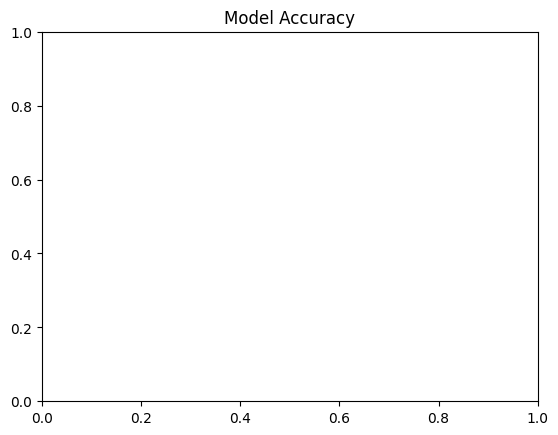

In [ ]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [ ]:
keras.model.save("model.h5")

NameError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________
